#JON IRASTORZA ANCÍN - Analisis de topicos en el conjunto de datos de Basqueparl

#1. Importar librerías

In [1]:
import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

In [4]:
import pandas as pd
import numpy as np
import pickle

# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

import seaborn as sns
import random

In [5]:
!pip install pyldavis
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



#2. Lectura y adecuación de los datos

In [ ]:
csv = '/basqueparl-v1.1.tsv'
df = pd.read_csv(csv, delimiter='\t')

In [ ]:
#Para eliminar discursos en euskera
df = df[df['language'] != 'eu']

In [ ]:
def condensar_por(dataset, columna1, columna2):
    grouped = dataset.groupby([columna1, columna2]).agg(lambda x: ' '.join(x) if x.name in ['text', 'lemmas', 'lemmas_stw', 'entities', 'entities_stw'] else x.iloc[0]).reset_index()
    return grouped


In [ ]:
df = condensar_por(df, 'speech_id', 'date')

In [ ]:
#Solo nos importa el año
split_date = df['date'].str.split('-', expand=True)
df['date'] = split_date[0]

In [ ]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
import nltk

def find_and_replace_collocations(texts, top_k):
    words = [word for text in texts for word in text.split(" ")]
    finder = BigramCollocationFinder.from_words(words)
    bgm = BigramAssocMeasures()
    collocations = {bigram: pmi for bigram , pmi in finder.score_ngrams(bgm.mi_like)}
    top_collocations = { ' '.join(col) : '_'.join(col) for i, col in enumerate(collocations.keys()) if i < top_k }
    print(top_collocations)

    texts_bigrams = []
    for i, text in enumerate(texts):

        for col in top_collocations:
            if col == " ":
              print('Falla')
              
            text = text.replace(col, top_collocations[col])
        texts_bigrams.append(text.split(" "))
    return texts_bigrams

texts = find_and_replace_collocations(df["lemmas_stw"].to_list(), top_k=2000)
df['preproc'] = [" ".join(text) for text in texts]

{'Eh Bildu': 'Eh_Bildu', 'Comunidad Autónoma': 'Comunidad_Autónoma', 'Unión Europea': 'Unión_Europea', 'Elkarrekin Podemos': 'Elkarrekin_Podemos', 'millón euro': 'millón_euro', 'derechos humanos': 'derechos_humanos', 'Euskal Herria': 'Euskal_Herria', 'comunidad autónomo': 'comunidad_autónomo', 'Nacionalista Vasco': 'Nacionalista_Vasco', 'Congreso Diputados': 'Congreso_Diputados', 'zurea hitza': 'zurea_hitza', 'Diputación Foral': 'Diputación_Foral', 'Garantía Ingresos': 'Garantía_Ingresos', 'País Vasco': 'País_Vasco', 'Derechos Humanos': 'Derechos_Humanos', 'Estados Unidos': 'Estados_Unidos', 'Medio Ambiente': 'Medio_Ambiente', 'Seguridad Social': 'Seguridad_Social', 'Naciones Unidas': 'Naciones_Unidas', 'Tribunal Constitucional': 'Tribunal_Constitucional', 'Formación Profesional': 'Formación_Profesional', 'Poder Judicial': 'Poder_Judicial', 'Nacionalistas Vascos': 'Nacionalistas_Vascos', 'San Sebastián': 'San_Sebastián', 'Concierto Económico': 'Concierto_Económico', 'jauna zurea': 'jau

In [ ]:
df.to_csv('/content/drive/MyDrive/MDT/PROYECTO/preprocesado.tsv', sep='\t', index=False)

#3. Aproximación LDA

##3.1 Visualización de los datos

Lectura de datos previamente preprocesados

In [ ]:
csv = '/content/drive/MyDrive/MDT/PROYECTO/preprocesado.tsv'
df = pd.read_csv(csv, delimiter='\t')

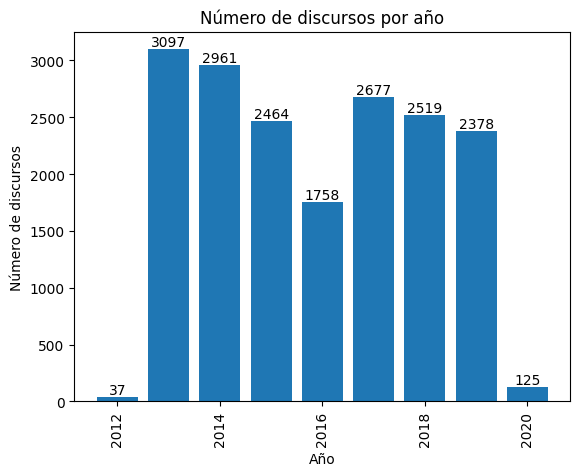

In [ ]:
#Discursos por año
speech_count = df['date'].value_counts().sort_index()

plt.bar(speech_count.index, speech_count.values)
plt.xlabel('Año')
plt.ylabel('Número de discursos')
plt.title('Número de discursos por año')
plt.xticks(rotation=90) 

for i, value in enumerate(speech_count.values):
    plt.text(speech_count.index[i], value, str(value), ha='center', va='bottom')

plt.show()

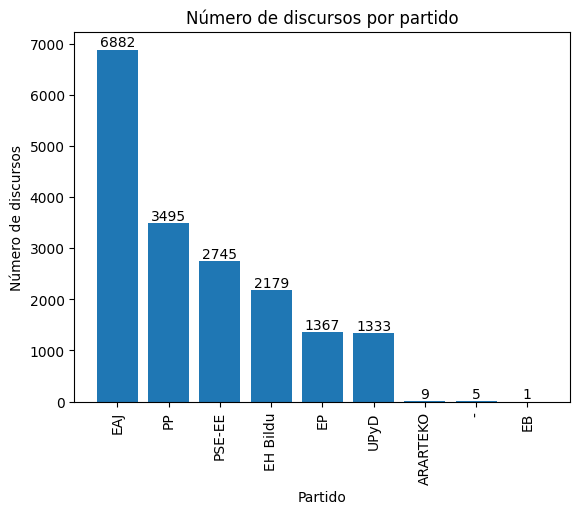

In [ ]:
#Discursos por partido
speech_count = df['party'].value_counts()

plt.bar(speech_count.index, speech_count.values)
plt.xlabel('Partido')
plt.ylabel('Número de discursos')
plt.title('Número de discursos por partido')
plt.xticks(rotation=90)  

for i, value in enumerate(speech_count.values):
    plt.text(speech_count.index[i], value, str(value), ha='center', va='bottom')

plt.show()

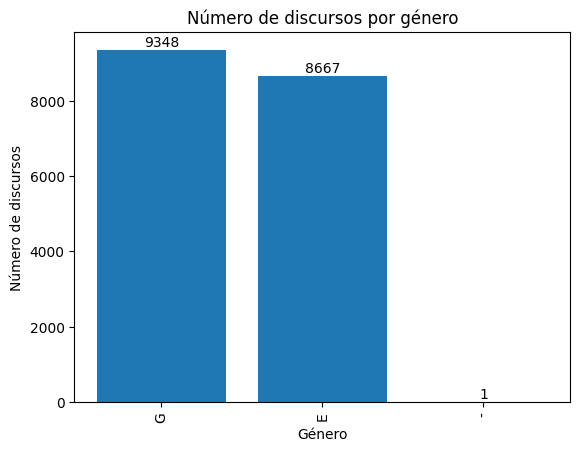

In [ ]:
#Discursos por género
speech_count = df['gender'].value_counts()

plt.bar(speech_count.index, speech_count.values)
plt.xlabel('Género')
plt.ylabel('Número de discursos')
plt.title('Número de discursos por género')
plt.xticks(rotation=90)

for i, value in enumerate(speech_count.values):
    plt.text(speech_count.index[i], value, str(value), ha='center', va='bottom')

plt.show()

##3.2 Entrenamiento de modelos

Vectorización de los textos

In [ ]:
max_df = 0.6
min_df = 300
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(strip_accents = 'unicode',
                             lowercase = True,
                             token_pattern = r'\b[a-zA-Z\-\_\d]{3,}\b',
                             max_df = max_df, 
                             min_df = min_df)

# apply transformation
tf = vectorizer.fit_transform(df['preproc'])

tf_feature_names = vectorizer.get_feature_names_out()

In [ ]:
print("El número final de features con max_df = {} y min_df = {} es: {}".format(max_df,min_df,len(tf_feature_names)))

El número final de features con max_df = 0.6 y min_df = 300 es: 1497


Entrenamiento del modelo

In [ ]:
number_of_topics = 30
best_lda_model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
best_lda_model.fit(tf)

LatentDirichletAllocation(n_components=30, random_state=0)

Guardado del modelo

In [ ]:
filename = '/content/drive/MyDrive/MDT/PROYECTO/modelo_lda_'+str(max_df)+"_"+str(min_df)+'_'+str(number_of_topics)+'.sav'
pickle.dump(best_lda_model, open(filename, 'wb'))

##3.3 Modelos entrenados

###Funciones

In [7]:
def row_norm(dists):
    # row normalization function required
    # for doc_topic_dists and topic_term_dists
    return dists / dists.sum(axis=1)[:, None]

def get_doc_topic_dists(lda_model, dtm):
    return row_norm(lda_model.transform(dtm))

def display_topics(model, feature_names, no_top_words, top_topics=None):
    topic_dict = {}
    if top_topics is None:
        topics = range(len(model.components_))
    else:
        topics = top_topics

    for topic_idx in topics:
        topic = model.components_[topic_idx]
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

def display_topics(model, feature_names, no_top_words, top_topics=None):
    topic_dict = {}
    if top_topics is None:
        topics = range(len(model.components_))
    else:
        topics = top_topics

    for topic_idx in topics:
        topic = model.components_[topic_idx]
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

### 3.2.1 Modelo 1

In [8]:
csv = '/content/drive/MyDrive/MDT/PROYECTO/preprocesado.tsv'
df = pd.read_csv(csv, delimiter='\t')

number_of_topics = 30
max_df = 0.6
min_df = 300

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(strip_accents = 'unicode',
                             lowercase = True,
                             token_pattern = r'\b[a-zA-Z\-\_\d]{3,}\b',
                             max_df = max_df, 
                             min_df = min_df)

# apply transformation
tf = vectorizer.fit_transform(df['preproc'])
tf_feature_names = vectorizer.get_feature_names_out()
print("El número final de features con max_df = {} y min_df = {} es: {}".format(max_df,min_df,len(tf_feature_names)))

modelo1 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
filename = '/content/drive/MyDrive/MDT/PROYECTO/modelo_lda_'+str(max_df)+"_"+str(min_df)+'_'+str(number_of_topics)+'.sav'
modelo1 = pickle.load(open(filename, 'rb'))
pyLDAvis.lda_model.prepare(modelo1, tf, vectorizer, mds='tsne')

El número final de features con max_df = 0.6 y min_df = 300 es: 1497


PreparedData(topic_coordinates=               x          y  topics  cluster      Freq
topic                                                 
15     -9.766099  45.283607       1        1  8.416124
18    -41.093624 -36.622753       2        1  6.928076
6       2.668334 -56.536484       3        1  5.974411
3      38.774597   1.417301       4        1  5.357721
23    -64.758484   9.479568       5        1  4.757181
2      -2.680737  24.393167       6        1  4.647172
5      27.921976  57.180424       7        1  3.676261
0     -18.501221  -9.571870       8        1  3.594013
14    -19.594830  11.468208       9        1  3.535006
10    -23.806515 -55.824963      10        1  3.322177
12     32.723392 -50.418591      11        1  3.230906
26      1.153095  66.238754      12        1  3.117818
13     34.820896 -25.374798      13        1  3.000877
20     17.865173  13.839422      14        1  2.996192
24     57.794731 -17.150850      15        1  2.889397
27     12.093225 -34.958279      16        1  2.733759
29     13.654676  38.636429      17        1  2.687828
4     -15.671052 -32.598019      18        1  2.685881
11     51.711086  42.322376      19        1  2.668050
28      0.634471 -17.902834      20        1  2.638476
7     -32.117260  57.434959      21        1  2.436871
1     -52.513226  35.732201      22        1  2.340390
16    -61.561287 -18.536390      23        1  2.327463
22    -38.591900 -12.190670      24        1  2.248462
19     34.421417  26.606386      25        1  2.238588
17     19.656343  -8.845889      26        1  2.231039
9     -28.135773  31.572826      27        1  2.076597
25     59.257797  13.650435      28        1  1.809927
8     -41.116360  10.772477      29        1  1.724946
21      0.269726   3.112929      30        1  1.708391, topic_info=             Term          Freq         Total Category  logprob  loglift
527       empresa  10196.000000  10196.000000  Default  30.0000  30.0000
1185     proyecto   9055.000000   9055.000000  Default  29.0000  29.0000
594           eta   5712.000000   5712.000000  Default  28.0000  28.0000
1080         plan   9234.000000   9234.000000  Default  27.0000  27.0000
1144  presupuesto   5337.000000   5337.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1200       querer    402.297129  22359.418868  Topic30  -4.6339   0.0518
1035      parecer    312.954869  11767.740748  Topic30  -4.8851   0.4426
1029         pais    248.762792   7973.748778  Topic30  -5.1146   0.6022
545      entender    212.182031   9516.803544  Topic30  -5.2737   0.2662
98            ano    212.649650  21768.264628  Topic30  -5.2715  -0.5589

[1501 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1         1  0.193744  10_ano
1         2  0.011397  10_ano
1         5  0.025073  10_ano
1         6  0.020514  10_ano
1         7  0.029631  10_ano
...     ...       ...     ...
1496     22  0.034519    zona
1496     23  0.022069    zona
1496     24  0.000566    zona
1496     26  0.035085    zona
1496     28  0.602098    zona

[17621 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 19, 7, 4, 24, 3, 6, 1, 15, 11, 13, 27, 14, 21, 25, 28, 30, 5, 12, 29, 8, 2, 17, 23, 20, 18, 10, 26, 9, 22])

In [9]:
doc_topic_dist = get_doc_topic_dists(modelo1, tf)
topic_prob = np.sum(doc_topic_dist, axis=0)
topic_prob = topic_prob / np.sum(topic_prob)
sorted_topics = np.argsort(-topic_prob)
sorted_topics
no_top_words= 10
disp = display_topics(modelo1, tf_feature_names, no_top_words, sorted_topics[:number_of_topics])

In [10]:
display(disp.iloc[:, np.arange(0,20) ])

Topic 15 words Topic 15 weights Topic 18 words Topic 18 weights   
0         querer           7076.4          creer           5415.9  \
1          creer           6198.0     iniciativa           3329.4   
2          venir           3316.5         debate           2985.9   
3          pasar           3168.4       plantear           2744.2   
4       problema           3118.7         querer           2537.5   
5        parecer           3070.3        parecer           2451.1   
6          mirar           2820.5      propuesta           2091.6   
7         llegar           2176.5       entender           1974.3   
8          gente           2027.5      presentar           1956.5   
9           pais           1927.2         llegar           1817.0   

   Topic 3 words Topic 3 weights   Topic 6 words Topic 6 weights   
0       defender          2501.6             ley          3044.9  \
1       politico          2394.9         decreto          2274.7   
2         espana          2022.1        articulo          1928.9   
3           caso          1847.6      establecer          1468.4   
4      ciudadano          1845.2           vasco          1392.8   
5  efectivamente          1831.7       normativa          1281.9   
6       proponer          1770.6    modificacion          1278.1   
7       plantear          1755.2         materia          1211.7   
8         gracia          1647.6  administracion          1207.5   
9     socialista          1575.5         aprobar          1161.4   

  Topic 2 words Topic 2 weights Topic 24 words Topic 24 weights   
0      politico          2393.4            eta           5754.5  \
1         vasco          1684.0        victima           1955.6   
2        querer          1565.2        memoria           1101.3   
3   democratico          1364.8       politico           1052.8   
4        debate          1185.4     terrorismo           1048.4   
5       euskadi          1121.5         querer            921.3   
6      cataluna          1110.1      violencia            921.0   
7        estado          1079.2    democratico            869.5   
8       derecho          1047.5          preso            798.6   
9  autogobierno          1018.8         seguir            748.3   

  Topic 23 words Topic 23 weights  Topic 14 words Topic 14 weights   
0        euskadi           3796.9         publico           3818.8  \
1          vasco           2845.2        servicio           2420.5   
2      economico           1866.2  administracion           1363.0   
3         social           1836.6      trabajador           1202.1   
4     compromiso           1718.9        contrato           1180.0   
5            ano           1556.0         gestion           1012.7   
6           pais           1481.9          querer            921.0   
7       objetivo           1421.6             ano            886.0   
8       economia           1187.8         empresa            882.1   
9         futuro           1177.2            caso            853.5   

  Topic 12 words Topic 12 weights Topic 26 words Topic 26 weights  
0       relacion           3366.0           caso           2392.2  
1          vasco           2652.3        informe           1537.6  
2        cultura           1625.9      actuacion           1036.6  
3       cultural           1326.6         delito            963.3  
4        europeo           1152.7  investigacion            897.8  
5     importante           1104.6    informacion            819.0  
6          creer           1101.1       fiscalia            757.3  
7        sentido           1092.4       denuncia            729.1  
8         gracia            972.2     corrupcion            726.1  
9  union_europea            938.0       judicial            698.6

In [11]:
display(disp.iloc[:, np.arange(20,40) ])

Topic 5 words Topic 5 weights Topic 0 words Topic 0 weights  Topic 10 words   
0       derecho          4861.8         pagar          2396.2     presupuesto  \
1      justicia          1580.5           ano          2315.6             ano   
2      tribunal          1299.5        fiscal          2027.9     millon_euro   
3         deber          1164.2      impuesto          1980.8         partida   
4      judicial          1081.6        dinero          1291.3  presupuestario   
5     sentencia           992.0        querer          1239.4          millon   
6      juridico           842.6      plantear          1233.1           gasto   
7           ley           840.4        espana          1045.5           vasco   
8          caso           839.9         venir          1000.4    presupuestos   
9     principio           775.4         vasco           951.6       inversion   

  Topic 10 weights Topic 20 words Topic 20 weights Topic 13 words   
0           4351.4        empresa           8119.8           plan  \
1           2773.2          vasco           1389.5       vivienda   
2           2012.2          fondo           1221.8       programa   
3           1737.8        publico           1192.5       objetivo   
4           1526.6     industrial           1083.0          joven   
5           1303.2        privado           1026.3     estrategia   
6           1135.3    empresarial            765.7          vasco   
7           1114.6      industria            756.2       alquiler   
8           1059.5      inversion            709.8       juventud   
9           1053.0           pais            660.1         accion   

  Topic 13 weights Topic 27 words Topic 27 weights Topic 1 words   
0           5898.9           dato           3269.2      proyecto  \
1           3307.1      situacion           2016.6          obra   
2           2376.6        lanbide           1589.7         vasco   
3           1232.8            ano           1515.1     presentar   
4           1189.5        pobreza           1028.0         plazo   
5           1008.6            mes            831.4           ano   
6            929.0        laboral            801.7    compromiso   
7            820.3      desempleo            718.3     necesario   
8            808.2         numero            644.2         deber   
9            763.0     inspeccion            625.0           mes   

  Topic 1 weights Topic 29 words Topic 29 weights    Topic 4 words   
0          7155.1          salud           2311.7         comercio  \
1          2229.7      seguridad           2196.9           bilbao   
2           824.5     ertzaintza           1778.4       transporte   
3           612.9       atencion           1214.8  infraestructura   
4           608.3        policia           1195.9        comercial   
5           571.4       servicio           1033.5            linea   
6           536.9    profesional            891.1          turismo   
7           507.0      sanitario            838.0           ciudad   
8           450.2         agente            813.7           barrio   
9           424.1      formacion            786.0            vasco   

  Topic 4 weights Topic 11 words Topic 11 weights  
0          1815.9          mujer           3441.6  
1          1373.3       igualdad           2522.4  
2          1293.9       sociedad            807.7  
3          1157.9         social            738.3  
4          1148.4           vida            725.8  
5          1109.5          deber            705.2  
6           968.8         ambito            687.0  
7           908.0         medida            640.1  
8           653.5        derecho            625.1  
9           651.0    desigualdad            625.1

In [12]:
display(disp.iloc[:, np.arange(40, 60) ])

Topic 28 words Topic 28 weights Topic 22 words Topic 22 weights   
0      situacion           1924.6    competencia           2521.2  \
1        laboral           1785.4   ayuntamiento           2119.0   
2         medida           1648.9          vasco           1912.8   
3     trabajador           1130.1      municipal           1227.1   
4        cuidado            657.4     diputacion            960.5   
5          juego            655.5      municipio            957.0   
6       familiar            627.9    institucion            858.3   
7       problema            621.8          foral            767.0   
8          deber            590.2          alava            739.5   
9           vida            580.5          local            697.0   

  Topic 19 words Topic 19 weights Topic 17 words Topic 17 weights   
0        familia           3225.5         centro           3400.5  \
1          ayuda           2891.4      educacion           2519.2   
2         social           1063.8        euskera           2288.0   
3     prestacion           1003.2      educativo           1137.4   
4            rgi            849.3    linguistico            961.8   
5            ano            816.8         lengua            937.9   
6        sistema            742.0        publico            861.3   
7      situacion            684.0        escolar            822.3   
8           hijo            633.8        escuela            752.0   
9      economico            625.6      ensenanza            741.7   

  Topic 8 words Topic 8 weights Topic 16 words Topic 16 weights Topic 7 words   
0    osakidetza          1602.4        energia           1101.0       sistema  \
1         salud          1209.6     produccion           1079.7       mejorar   
2      afectado           706.1     energetico            959.5        mejora   
3         banco           701.2       paciente            877.5     educacion   
4      problema           682.0     estrategia            824.6    evaluacion   
5      producto           649.4  investigacion            729.7       calidad   
6   informacion           600.5            ano            706.1     resultado   
7     sanitario           492.1    tratamiento            691.0     educativo   
8    consumidor           465.1       hospital            640.7       euskadi   
9          caso           464.3      industria            523.5           ano   

  Topic 7 weights     Topic 9 words Topic 9 weights  Topic 25 words   
0          2703.8              eitb          2077.0            zona  \
1          1153.8           pension          1865.9       seguridad   
2          1132.7           sistema          1696.0            agua   
3          1079.6           publico          1533.3           suelo   
4           847.1           reforma           914.9      proteccion   
5           806.6           gestion           829.8         control   
6           801.7       pensionista           800.1         tecnico   
7           762.6              ente           763.6             ano   
8           702.6  seguridad_social           673.8         espacio   
9           671.6             deber           659.3  medioambiental   

  Topic 25 weights         Topic 21 words Topic 21 weights  
0           1061.9                 modelo           2802.9  
1            833.5              sindicato           1494.6  
2            750.5             trabajador           1019.5  
3            678.0               convenio            935.3  
4            646.8                  creer            910.8  
5            535.6            universidad            727.5  
6            523.9               patronal            719.3  
7            480.6               sindical            681.7  
8            440.5  negociacion_colectivo            651.9  
9            431.9            negociacion            647.5

Nos quedamos solo con algunos de los topics y los renombramos

In [13]:
topics_model1 = {'Topico11':'Igualdad de genero', 'Topico20':'Empresa/Industria', 'Topico5':'Justicia', 'Topico10': 'Presupuestos', 'Topico6': 'Legislación', 
                 'Topico17':'Educación', 'Topico9': 'Ayudas sociales', 'Topico16': 'Energía', 'Topico8': 'Salud', 'Topico24': 'Terrorismo'}

In [14]:
pd.DataFrame(list(topics_model1.items()), columns=['Topico', 'Nombre asignado'])

Topico     Nombre asignado
0  Topico11  Igualdad de genero
1  Topico20   Empresa/Industria
2   Topico5            Justicia
3  Topico10        Presupuestos
4   Topico6         Legislación
5  Topico17           Educación
6   Topico9     Ayudas sociales
7  Topico16             Energía
8   Topico8               Salud
9  Topico24          Terrorismo

### 3.2.2 Modelo 2

In [15]:
csv = '/content/drive/MyDrive/MDT/PROYECTO/preprocesado.tsv'
df = pd.read_csv(csv, delimiter='\t')

number_of_topics = 40
max_df = 0.6
min_df = 150

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(strip_accents = 'unicode',
                             lowercase = True,
                             token_pattern = r'\b[a-zA-Z\-\_\d]{3,}\b',
                             max_df = max_df, 
                             min_df = min_df)

# apply transformation
tf = vectorizer.fit_transform(df['preproc'])
tf_feature_names = vectorizer.get_feature_names_out()
print("El número final de features con max_df = {} y min_df = {} es: {}".format(max_df,min_df,len(tf_feature_names)))

modelo2 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
filename = '/content/drive/MyDrive/MDT/PROYECTO/modelo_lda_'+str(max_df)+"_"+str(min_df)+'_'+str(number_of_topics)+'.sav'
modelo2 = pickle.load(open(filename, 'rb'))
pyLDAvis.lda_model.prepare(modelo2, tf, vectorizer, mds='tsne')

El número final de features con max_df = 0.6 y min_df = 150 es: 2610


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
34    -3.070681  4.920042       1        1  5.419449
15    -3.225397  4.687942       2        1  5.188475
5     -3.215848  5.562308       3        1  4.578652
7     -2.102767  4.863428       4        1  4.365559
32    -3.326519  4.873209       5        1  4.179802
33    -3.119975  4.757271       6        1  3.969984
12    -3.120323  5.966776       7        1  3.558193
4     -1.795515  5.746970       8        1  3.199031
20    -2.793829  4.354463       9        1  3.067148
30    -1.836705  5.117765      10        1  2.998043
24    -1.824681  5.785149      11        1  2.961972
0     -1.330501  5.289698      12        1  2.960608
22    -1.888291  5.809787      13        1  2.776835
35    -1.914095  5.702218      14        1  2.697814
26    -2.392574  5.453883      15        1  2.633563
27    -1.793292  5.085941      16        1  2.503397
13    -2.287568  6.075184      17        1  2.488131
17    -2.951021  6.184456      18        1  2.440688
3     -2.507692  6.148648      19        1  2.363281
10    -2.980608  4.711998      20        1  2.362505
2     -2.213661  4.886816      21        1  2.220109
23    -2.548194  5.922369      22        1  2.197983
16    -2.234174  5.610347      23        1  2.167231
1     -2.775978  5.118563      24        1  2.034448
6     -2.817091  5.521634      25        1  1.924239
28    -2.120414  4.790827      26        1  1.889044
25    -1.886698  6.051999      27        1  1.876837
29    -1.889023  4.634719      28        1  1.865791
37    -1.634597  4.926304      29        1  1.849342
31    -3.063920  5.420344      30        1  1.785844
21    -3.473240  4.444733      31        1  1.713343
38    -1.684717  5.600457      32        1  1.678382
19    -3.272640  5.000580      33        1  1.670173
11    -3.184229  5.429354      34        1  1.528150
14    -2.519884  6.202120      35        1  1.493646
9     -3.549117  5.967836      36        1  1.310472
36    -2.212120  6.594861      37        1  1.253845
39    -3.074949  6.059618      38        1  1.210596
8     -1.532065  4.609184      39        1  1.018022
18    -3.641674  3.882014      40        1  0.599372, topic_info=          Term          Freq         Total Category  logprob  loglift
943    empresa  10278.000000  10278.000000  Default  30.0000  30.0000
1060       eta   5676.000000   5676.000000  Default  29.0000  29.0000
2587  vivienda   3825.000000   3825.000000  Default  28.0000  28.0000
2312  servicio   6962.000000   6962.000000  Default  27.0000  27.0000
2333   sistema   7715.000000   7715.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
178     andrea    205.619548    265.025998  Topic40  -4.3873   4.8632
995        ere    632.654687    850.939114  Topic40  -3.2635   4.8206
1002      esar    130.111633    229.605050  Topic40  -4.8450   4.5491
1060       eta   3038.697303   5676.244063  Topic40  -1.6942   4.4922
1225   garrido    134.892404    695.864530  Topic40  -4.8089   3.4764

[2137 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1         2  0.023749  1000
1         4  0.014843  1000
1         6  0.002969  1000
1         8  0.008906  1000
1         9  0.341388  1000
...     ...       ...   ...
2608     27  0.000573  zona
2608     29  0.017766  zona
2608     32  0.004012  zona
2608     34  0.000573  zona
2609     40  0.997391  zuen

[25427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[35, 16, 6, 8, 33, 34, 13, 5, 21, 31, 25, 1, 23, 36, 27, 28, 14, 18, 4, 11, 3, 24, 17, 2, 7, 29, 26, 30, 38, 32, 22, 39, 20, 12, 15, 10, 37, 40, 9, 19])

In [16]:
number_of_topics = 40
max_df = 0.6
min_df = 150

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(strip_accents = 'unicode',
                             lowercase = True,
                             token_pattern = r'\b[a-zA-Z\-\_\d]{3,}\b',
                             max_df = max_df, 
                             min_df = min_df)

# apply transformation
tf = vectorizer.fit_transform(df['preproc'])
tf_feature_names = vectorizer.get_feature_names_out()

In [17]:
doc_topic_dist = get_doc_topic_dists(modelo2, tf)
topic_prob = np.sum(doc_topic_dist, axis=0)
topic_prob = topic_prob / np.sum(topic_prob)
sorted_topics = np.argsort(-topic_prob)
sorted_topics
no_top_words= 10
disp = display_topics(modelo2, tf_feature_names, no_top_words, sorted_topics[:number_of_topics])

In [18]:
display(disp.iloc[:, np.arange(0, 20) ])

Topic 15 words Topic 15 weights Topic 34 words Topic 34 weights   
0         querer           3736.1          creer           8637.5  \
1          mirar           2534.6         querer           3553.3   
2          venir           2461.6         debate           2130.1   
3          creer           2171.8         llegar           2063.9   
4        popular           2120.2       entender           2037.2   
5          pasar           2005.7       ponencia           1994.4   
6        parecer           1851.4        parecer           1935.0   
7          pedir           1727.2      propuesta           1635.6   
8     socialista           1262.6       problema           1541.3   
9         llegar           1179.9          venir           1153.3   

  Topic 5 words Topic 5 weights      Topic 32 words Topic 32 weights   
0           ley          2902.3            defender           1956.1  \
1    iniciativa          2138.7            politico           1860.9   
2       aprobar          2093.0       efectivamente           1660.6   
3      enmienda          2040.5            plantear           1656.6   
4   proposicion          1936.2           ciudadano           1609.5   
5        debate          1541.4            proponer           1587.6   
6  modificacion          1540.6                caso           1568.0   
7     presentar          1489.9              espana           1520.7   
8    socialista          1391.7               vasco           1418.2   
9         texto          1370.3  nacionalista_vasco           1334.2   

  Topic 33 words Topic 33 weights Topic 12 words Topic 12 weights   
0       politico           1852.8           caso           2040.2  \
1         querer           1733.2       justicia           1774.3   
2          vasco           1710.4       judicial           1676.2   
3         estado           1501.2        derecho           1607.9   
4        derecho           1421.3       tribunal           1566.2   
5        euskadi           1264.9      sentencia           1251.3   
6       cataluna           1131.5        publico           1079.5   
7    democratico           1105.9  procedimiento           1027.4   
8         espana            977.6          deber            955.6   
9   autogobierno            833.7     resolucion            933.9   

       Topic 2 words Topic 2 weights Topic 7 words Topic 7 weights   
0          educacion          2495.5        social          2485.7  \
1          educativo          1028.0        modelo          2151.0   
2             centro           884.4         deber          1865.8   
3             ingles           825.9       euskadi          1761.7   
4             querer           733.2          pais          1546.0   
5             lengua           725.9      sociedad          1442.2   
6                ano           709.7    ciudadania          1331.1   
7  sistema_educativo           706.1       publico          1196.2   
8              creer           697.8        querer          1121.1   
9            escuela           639.2        futuro          1020.3   

  Topic 30 words Topic 30 weights Topic 18 words Topic 18 weights  
0          vasco           2104.1            eta           3137.8  
1     compromiso           1789.8            ere            653.3  
2        euskadi           1566.5            bat            641.0  
3       proyecto           1363.7           hori            532.0  
4       programa           1288.6           esan            464.1  
5            ano           1202.1          baina            449.0  
6       objetivo            990.4           dugu            414.0  
7      economico            808.8           egin            410.0  
8         seguir            654.8           izan            402.0  
9    estabilidad            585.0           zuen            381.0

In [19]:
display(disp.iloc[:, np.arange(20, 40) ])

Topic 4 words Topic 4 weights   Topic 24 words Topic 24 weights   
0         vasco          3145.4         relacion           2915.1  \
1       cultura          1656.0             plan           2890.7   
2       euskadi          1500.6       importante           1286.1   
3      cultural          1349.6            creer           1179.8   
4      proyecto          1009.5          sentido           1165.0   
5        ambito           892.8  economia_social            925.0   
6      programa           836.9       iniciativa            919.7   
7      objetivo           740.9           ambito            902.8   
8    desarrollo           675.5        actuacion            805.5   
9  colaboracion           628.6        documento            777.4   

  Topic 20 words Topic 20 weights   Topic 0 words Topic 0 weights   
0            ano           2433.0     presupuesto          3395.2  \
1          pagar           1948.5             ano          2478.8   
2         dinero           1488.6     millon_euro          1818.1   
3         querer           1449.8         partida          1578.2   
4          venir           1143.0  presupuestario          1415.6   
5    presupuesto           1125.4           vasco          1191.1   
6          vasco           1024.9           gasto          1190.1   
7       plantear           1020.4           ayuda          1085.2   
8          gente           1003.4          millon          1085.0   
9       impuesto            871.2            euro           996.1   

   Topic 17 words Topic 17 weights    Topic 10 words Topic 10 weights   
0         informe           2271.5           victima           2028.7  \
1         publico           1258.6           memoria           1106.4   
2  administracion           1181.2         violencia           1043.0   
3        comision            932.5       convivencia            889.1   
4             ano            820.2  derechos_humanos            834.7   
5   investigacion            704.4           deporte            730.6   
6           vasco            604.4             deber            605.0   
7     funcionario            566.6             vasco            586.4   
8     informacion            529.8               paz            570.5   
9          estado            513.9            querer            549.3   

  Topic 26 words Topic 26 weights Topic 13 words Topic 13 weights   
0        empresa           5381.0          salud           3507.8  \
1        publico           1569.3     osakidetza           2097.4   
2          fondo           1240.8      sanitario           1555.3   
3        privado           1130.1    profesional           1040.2   
4     industrial           1027.9       paciente            974.7   
5          vasco            994.1         medico            879.9   
6       proyecto            810.3       hospital            840.6   
7      inversion            750.9       servicio            827.9   
8          ayuda            689.3        sanidad            764.3   
9      industria            681.0       atencion            752.4   

    Topic 23 words Topic 23 weights   Topic 3 words Topic 3 weights  
0         proyecto           2121.3    ayuntamiento          1823.9  
1             obra           1743.7       municipal          1084.1  
2           bilbao           1378.9      diputacion          1004.7  
3  infraestructura           1253.3     competencia           896.5  
4            linea            982.9           alava           895.8  
5            vasco            647.6             ano           871.6  
6       transporte            615.5       municipio           799.5  
7           barrio            607.5  administracion           724.3  
8              ano            586.4     institucion           716.3  
9          estudio            572.6            agua           678.6

In [20]:
display(disp.iloc[:, np.arange(40, 60) ])

Topic 21 words Topic 21 weights Topic 27 words Topic 27 weights   
0            eta           2367.6           dato           2882.5  \
1       politico           1113.8        lanbide           2112.9   
2    democratico            708.7      situacion           1527.3   
3       defender            701.1            ano           1310.1   
4     terrorismo            695.7      desempleo            628.6   
5       condenar            676.6            mes            604.7   
6         querer            662.4         social            537.1   
7         seguir            594.0       ararteko            533.8   
8     democracia            495.8        euskadi            528.0   
9     terrorista            434.0         numero            495.2   

  Topic 22 words Topic 22 weights Topic 35 words Topic 35 weights   
0        familia           2180.2       comercio           1726.8  \
1       familiar            998.2        turismo           1215.9   
2        decreto            970.9      turistico           1162.3   
3          ayuda            947.7      comercial           1049.2   
4       atencion            811.6           zona            981.4   
5         medida            773.5      actividad            941.9   
6         social            735.7     produccion            739.7   
7         ambito            685.0          rural            701.9   
8       igualdad            642.7          deber            552.2   
9          vasco            635.6        agrario            537.9   

  Topic 6 words Topic 6 weights  Topic 1 words Topic 1 weights Topic 19 words   
0    ertzaintza          2470.3  union_europea          1193.1          banco  \
1     seguridad          2279.2        europeo          1118.1       problema   
2       euskera          1526.9           pais           793.0         querer   
3       policia          1449.8          vasco           769.6      kutxabank   
4        agente           841.3         europa           693.5       plantear   
5      policial           687.8         puerto           681.2           caja   
6   linguistico           505.3    informacion           657.3           caso   
7     ciudadano           424.7       producto           636.1        parecer   
8        cuerpo           409.2        campana           554.5         fraude   
9        delito           407.0      situacion           528.5     financiero   

  Topic 19 weights Topic 16 words Topic 16 weights Topic 25 words   
0            844.5        laboral           1562.0         centro  \
1            833.9     iniciativa            998.2      formacion   
2            786.8         medida            975.8    competencia   
3            617.2          creer            879.1      educacion   
4            610.5     inspeccion            841.5      educativo   
5            579.9           plan            818.6         modelo   
6            561.4     trabajador            679.4        sistema   
7            559.2       objetivo            528.7          deber   
8            525.9      seguridad            514.5        escolar   
9            487.0      accidente            501.0          curso   

  Topic 25 weights Topic 11 words Topic 11 weights  
0           2570.1           eitb           2076.3  
1           1014.8        publico           1054.6  
2            963.2           ente            764.3  
3            930.7      direccion            664.4  
4            796.0     television            478.9  
5            690.6          deber            461.1  
6            672.1    profesional            425.8  
7            610.0    informacion            393.0  
8            564.2          radio            391.0  
9            527.6    informativo            382.5

In [21]:
display(disp.iloc[:, np.arange(60, 80) ])

Topic 31 words Topic 31 weights      Topic 28 words   
0             trabajador           2229.5               mujer  \
1              sindicato           1543.7            igualdad   
2            negociacion            951.1           violencia   
3               sindical            725.4               juego   
4               patronal            692.4  violencia_machista   
5                derecho            649.0              medida   
6  negociacion_colectivo            636.1            sociedad   
7                laboral            572.4          prevencion   
8         dialogo_social            527.5    violencia_genero   
9        reforma_laboral            488.5                 ano   

  Topic 28 weights    Topic 29 words Topic 29 weights    Topic 38 words   
0           2284.4           sistema           3819.0           energia  \
1           1340.6           pension           1915.4        energetico   
2            771.9       pensionista            852.8        transporte   
3            608.3           publico            720.4         electrico   
4            597.4            medida            675.7        estrategia   
5            577.3           reforma            626.2               ano   
6            457.2            social            625.4          objetivo   
7            445.6  seguridad_social            570.7               gas   
8            432.2         economico            556.9           euskadi   
9            422.7           popular            524.5  cambio_climatico   

  Topic 38 weights     Topic 14 words Topic 14 weights Topic 37 words   
0           1158.3           servicio           3145.6         fiscal  \
1           1031.4            publico            955.8          joven   
2            640.5          condicion            645.3       impuesto   
3            600.6        trabajadora            619.8        euskadi   
4            579.4         trabajador            578.5       juventud   
5            476.0            calidad            521.1           tasa   
6            463.9           personal            483.0            ano   
7            460.6   servicio_publico            458.0           pais   
8            459.9  condicion_laboral            444.0           dato   
9            418.3         emergencia            405.9     fiscalidad   

  Topic 37 weights  Topic 9 words Topic 9 weights  Topic 39 words   
0           1790.9  penitenciario           954.2         empresa  \
1           1271.2  transferencia           821.9        contrato   
2           1021.0          preso           606.7    contratacion   
3            939.5        prision           521.4         publico   
4            759.5        cumplir           518.6        clausula   
5            729.3    competencia           512.5          precio   
6            714.4        derecho           511.1       condicion   
7            647.4        espanol           486.9         cumplir   
8            643.3           pena           485.4          social   
9            583.2         delito           414.5  administracion   

  Topic 39 weights     Topic 36 words Topic 36 weights       Topic 8 words   
0           2237.9           vivienda           3657.8           situacion  \
1           1275.5           alquiler            863.7               mujer   
2           1071.2            derecho            648.6             pobreza   
3            841.7            publico            460.0              medida   
4            621.5           registro            432.2             familia   
5            464.7       ley_vivienda            338.3               hogar   
6            375.4                ley            331.0               vasco   
7            301.5  derecho_subjetivo            323.5         desigualdad   
8            295.4              deber            302.5  pobreza_energetico   
9            292.5                ano            300.0             cuidado   

  Topic 8 weights  
0          1004.9  
1    

Nos quedamos solo con algunos de los topics y los renombramos

In [22]:
topics_model2 = {'Topico28':'Igualdad de genero', 'Topico26':'Empresa/Industria', 'Topico12':'Justicia', 'Topico0': 'Presupuestos', 'Topico5': 'Legislación', 
                 'Topico2':'Educación', 'Topico29': 'Ayudas sociales', 'Topico38': 'Energía', 'Topico13': 'Salud', 'Topico6': 'Seguridad', 'Topico31': 'Sindicatos' , 
                 'Topico21': 'Terrorismo', 'Topico36': 'Vivienda', 'Topico9': 'Presos', 'Topico19': 'Banca', 'Topico37': 'Fiscalidad'}

In [23]:
pd.DataFrame(list(topics_model2.items()), columns=['Topico', 'Nombre asignado'])

Topico     Nombre asignado
0   Topico28  Igualdad de genero
1   Topico26   Empresa/Industria
2   Topico12            Justicia
3    Topico0        Presupuestos
4    Topico5         Legislación
5    Topico2           Educación
6   Topico29     Ayudas sociales
7   Topico38             Energía
8   Topico13               Salud
9    Topico6           Seguridad
10  Topico31          Sindicatos
11  Topico21          Terrorismo
12  Topico36            Vivienda
13   Topico9              Presos
14  Topico19               Banca
15  Topico37          Fiscalidad

###3.2.3 Modelo3

In [24]:
csv = '/content/drive/MyDrive/MDT/PROYECTO/preprocesado.tsv'
df = pd.read_csv(csv, delimiter='\t')

number_of_topics = 40
max_df = 0.6
min_df = 300

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(strip_accents = 'unicode',
                             lowercase = True,
                             token_pattern = r'\b[a-zA-Z\-\_\d]{3,}\b',
                             max_df = max_df, 
                             min_df = min_df)

# apply transformation
tf = vectorizer.fit_transform(df['preproc'])
tf_feature_names = vectorizer.get_feature_names_out()
print("El número final de features con max_df = {} y min_df = {} es: {}".format(max_df,min_df,len(tf_feature_names)))

modelo3 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
filename = '/content/drive/MyDrive/MDT/PROYECTO/modelo_lda_'+str(max_df)+"_"+str(min_df)+'_'+str(number_of_topics)+'.sav'
modelo3 = pickle.load(open(filename, 'rb'))
pyLDAvis.lda_model.prepare(modelo3, tf, vectorizer, mds='tsne')

El número final de features con max_df = 0.6 y min_df = 300 es: 1497


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     5.678062 -2.008443       1        1  7.372785
3      5.631009 -2.134163       2        1  5.097303
6      6.745947 -1.519494       3        1  4.693445
23     6.220830 -0.785613       4        1  4.173808
18     5.928875 -1.801340       5        1  4.157125
2      6.003541 -2.151431       6        1  3.824196
34     4.951741 -1.243046       7        1  3.189500
35     6.500938 -0.529400       8        1  3.092449
29     6.809405 -0.932998       9        1  2.797315
27     6.099373 -0.419139      10        1  2.740869
5      6.684597 -2.036468      11        1  2.718782
30     5.315551 -1.216831      12        1  2.714704
37     5.917817 -1.921575      13        1  2.709257
0      5.257254 -1.349014      14        1  2.508637
12     6.514711 -1.613586      15        1  2.491077
32     6.326136 -2.439674      16        1  2.409612
31     6.226544 -1.772274      17        1  2.408642
4      6.127483 -0.718947      18        1  2.287868
33     5.316556 -0.906732      19        1  2.284522
26     6.406042 -2.420691      20        1  2.276119
14     6.001618 -1.947510      21        1  2.190994
20     5.893965 -1.057308      22        1  2.174556
28     6.224999 -0.550833      23        1  2.141135
1      6.112277 -1.419821      24        1  2.123020
22     5.445719 -2.184144      25        1  2.113497
11     6.392970 -0.630378      26        1  2.025263
17     6.626162 -2.438135      27        1  1.903014
38     7.315238 -0.846094      28        1  1.878160
39     5.663165 -1.585623      29        1  1.689661
16     6.570219 -0.772842      30        1  1.672839
9      5.779227 -1.905819      31        1  1.614066
24     6.112279 -2.932416      32        1  1.576104
36     5.024379 -1.732474      33        1  1.561964
7      6.906582 -0.376636      34        1  1.560214
25     7.050682 -1.407022      35        1  1.506302
8      7.479800 -0.831017      36        1  1.393283
10     5.808875 -0.964241      37        1  1.358251
19     6.854840 -0.481190      38        1  1.341513
21     7.070158 -1.504078      39        1  1.166527
13     6.078032 -0.195464      40        1  1.061622, topic_info=          Term          Freq         Total Category  logprob  loglift
527    empresa  10175.000000  10175.000000  Default  30.0000  30.0000
1185  proyecto   8895.000000   8895.000000  Default  29.0000  29.0000
594        eta   5549.000000   5549.000000  Default  28.0000  28.0000
1080      plan   9120.000000   9120.000000  Default  27.0000  27.0000
1485  vivienda   3812.000000   3812.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
365      creer    215.585968  23419.832261  Topic40  -4.7820  -0.1426
396      deber    173.636402  15618.058351  Topic40  -4.9984   0.0462
1171  programa    105.302020   4601.176799  Topic40  -5.4985   0.7681
204       caso    109.723701  13221.381657  Topic40  -5.4574  -0.2463
1200    querer    106.119614  22317.595950  Topic40  -5.4908  -0.8032

[2019 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1         1  0.174434  10_ano
1         4  0.009062  10_ano
1         5  0.002265  10_ano
1         6  0.018123  10_ano
1         7  0.074758  10_ano
...     ...       ...     ...
1496     35  0.036831    zona
1496     36  0.015299    zona
1496     37  0.009633    zona
1496     38  0.027765    zona
1496     40  0.002267    zona

[25600 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 4, 7, 24, 19, 3, 35, 36, 30, 28, 6, 31, 38, 1, 13, 33, 32, 5, 34, 27, 15, 21, 29, 2, 23, 12, 18, 39, 40, 17, 10, 25, 37, 8, 26, 9, 11, 20, 22, 14])

In [25]:
doc_topic_dist = get_doc_topic_dists(modelo3, tf)
topic_prob = np.sum(doc_topic_dist, axis=0)
topic_prob = topic_prob / np.sum(topic_prob)
sorted_topics = np.argsort(-topic_prob)
sorted_topics
no_top_words= 10
disp = display_topics(modelo3, tf_feature_names, no_top_words, sorted_topics[:number_of_topics])

In [26]:
display(disp.iloc[:, np.arange(0, 20) ])

Topic 15 words Topic 15 weights  Topic 3 words Topic 3 weights   
0         querer           6983.2       defender          2438.0  \
1          creer           4399.9       politico          2064.9   
2          venir           3099.1       plantear          1948.2   
3          pasar           2769.2         espana          1941.9   
4        parecer           2679.7  efectivamente          1914.9   
5          mirar           2637.6     iniciativa          1888.9   
6       problema           2470.2       proponer          1768.2   
7         debate           2085.7         gracia          1712.2   
8         llegar           1950.1          creer          1679.4   
9          gente           1892.4           caso          1674.3   

  Topic 18 words Topic 18 weights   Topic 6 words Topic 6 weights   
0          creer           2353.0             ley          2933.4  \
1        informe           2219.8        articulo          1848.0   
2       plantear           1791.1      establecer          1338.6   
3     iniciativa           1764.2       normativa          1317.7   
4       ponencia           1714.0    modificacion          1282.7   
5         debate           1668.0           norma          1066.1   
6         querer           1600.4         materia          1053.9   
7        parecer           1337.2  administracion          1046.9   
8      propuesta           1245.5         publico           976.6   
9        decreto           1223.8           deber           956.7   

  Topic 2 words Topic 2 weights Topic 37 words Topic 37 weights   
0      politico          2256.8          creer           4185.9  \
1   democratico          1390.6        lanbide           1821.8   
2        querer          1231.7       entender           1304.2   
3         vasco          1194.9        parecer           1169.2   
4        debate          1155.8           dato            937.6   
5      cataluna          1125.4         querer            802.1   
6        estado          1026.4        mejorar            607.0   
7  autogobierno           982.5       criterio            599.2   
8       euskadi           863.4          forma            577.9   
9    democracia           854.8        gestion            561.8   

  Topic 23 words Topic 23 weights Topic 24 words Topic 24 weights   
0        euskadi           4066.9            eta           5754.7  \
1          vasco           2890.6     terrorismo            841.4   
2      economico           1877.8          preso            796.4   
3           pais           1601.7       politico            777.4   
4            ano           1448.0            ere            641.2   
5         social           1361.9            bat            637.0   
6         futuro           1296.9    democratico            578.7   
7       objetivo           1281.6         seguir            542.2   
8     compromiso           1233.2           hori            531.8   
9       economia           1142.4         querer            510.4   

  Topic 30 words Topic 30 weights    Topic 32 words Topic 32 weights  
0          ayuda           1786.3         violencia           1195.5  
1            ano           1748.5              acto            860.2  
2          vasco           1402.8            querer            812.9  
3        familia           1198.9       declaracion            790.0  
4          punto            985.1  derechos_humanos            706.9  
5        aprobar            892.9             deber            587.4  
6            mes            786.8        cualquiera            511.3  
7     iniciativa            694.2           victima            510.1  
8      presentar            683.6              tipo            497.3  
9       relacion            671.4              pais            470.6

In [27]:
display(disp.iloc[:, np.arange(20, 40) ])

Topic 12 words Topic 12 weights Topic 31 words Topic 31 weights   
0       relacion           3085.2          creer           1334.2  \
1          vasco           2153.8    negociacion           1276.6   
2        cultura           1581.5        publico            927.4   
3       cultural           1325.9     compromiso            881.6   
4        europeo           1070.6    socialistas            760.6   
5        sentido            997.5      propuesta            732.1   
6         gracia            947.4      compartir            671.2   
7     importante            926.5        reunion            625.8   
8          creer            843.6         seguir            531.5   
9  union_europea            818.7          deber            497.8   

   Topic 34 words Topic 34 weights Topic 35 words Topic 35 weights   
0     presupuesto           4438.1           plan           6708.6  \
1             ano           2854.9       programa           3080.1   
2     millon_euro           1955.4       objetivo           1575.5   
3           gasto           1638.4     estrategia           1129.4   
4         partida           1453.2          vasco            988.3   
5  presupuestario           1350.4         medida            907.5   
6          millon           1343.1         accion            854.2   
7          dinero           1186.2         marcha            780.4   
8           vasco           1165.9      actuacion            775.5   
9            euro           1078.7     desarrollo            718.0   

    Topic 26 words Topic 26 weights Topic 27 words Topic 27 weights   
0             caso           2130.8           dato           3289.3  \
1      informacion           1130.6      situacion           2168.7   
2       corrupcion           1033.0            ano           1779.6   
3         fiscalia            809.7        pobreza           1098.7   
4         politico            764.8        laboral           1065.9   
5    investigacion            748.2        euskadi            873.1   
6    transparencia            745.5     inspeccion            738.6   
7          publico            734.9         numero            720.3   
8  responsabilidad            712.9      desempleo            660.3   
9            vasco            641.4         medida            601.0   

  Topic 5 words Topic 5 weights  Topic 14 words Topic 14 weights   
0       derecho          5021.6         publico           2094.1  \
1         deber          1007.8      trabajador           1921.6   
2     principio           762.1        contrato            951.8   
3      articulo           752.7  administracion            812.4   
4           ley           672.6          puesto            791.7   
5      libertad           630.3       plantilla            700.0   
6      justicia           615.7          querer            651.1   
7        acceso           567.8    contratacion            650.8   
8      tribunal           543.5             ope            641.2   
9       publico           541.9       sindicato            618.3   

  Topic 29 words Topic 29 weights Topic 0 words Topic 0 weights  
0         ambito           1586.9           ano          1726.6  
1          salud           1047.5       empresa          1608.2  
2     importante            787.1         fondo          1563.6  
3      actuacion            770.5      problema          1093.0  
4     prevencion            714.3         pagar          1049.7  
5   coordinacion            691.9         vasco           960.6  
6          creer            660.1        espana           941.7  
7       objetivo            652.3          pais           888.6  
8       atencion            652.3        dinero           823.6  
9           plan            629.5        millon           781.6

In [28]:
display(disp.iloc[:, np.arange(40, 60) ])

Topic 17 words Topic 17 weights Topic 1 words Topic 1 weights   
0        victima           1886.9      proyecto          7237.0  \
1       judicial           1575.0          obra          2047.5   
2       justicia           1538.4         vasco           677.7   
3        memoria           1128.5     presentar           536.6   
4       tribunal           1012.7     necesario           496.6   
5      sentencia            940.4  ayuntamiento           486.9   
6           caso            689.9         plazo           442.1   
7        proceso            593.9         deber           439.4   
8        maneiro            585.5           ano           420.1   
9  procedimiento            572.1    compromiso           385.8   

  Topic 22 words Topic 22 weights    Topic 4 words Topic 4 weights   
0    competencia           2898.5         comercio          1811.4  \
1          vasco           2084.6           bilbao          1284.2   
2   ayuntamiento           1897.1  infraestructura          1186.9   
3      municipal           1182.9       transporte          1158.6   
4      municipio            909.9        comercial          1116.4   
5     diputacion            744.7            linea          1086.9   
6         estado            731.6           ciudad           872.0   
7          local            685.5           barrio           679.4   
8        euskadi            683.8            vasco           571.6   
9    institucion            644.7       territorio           544.3   

  Topic 20 words Topic 20 weights Topic 38 words Topic 38 weights   
0        empresa           6811.8       servicio           4006.8  \
1     trabajador           1015.8         centro           2842.6   
2        publico            988.3       atencion           1145.9   
3        privado            875.1        gestion            817.1   
4          vasco            725.3      formacion            737.1   
5    empresarial            651.7       personal            624.0   
6          creer            622.8        decreto            507.5   
7           pais            622.5    profesional            483.4   
8        euskadi            594.3          curso            482.7   
9      condicion            504.3      necesidad            462.1   

  Topic 33 words Topic 33 weights Topic 28 words Topic 28 weights   
0        sistema           3663.9        familia           1614.3  \
1         social           1597.8      situacion           1540.3   
2     prestacion           1163.5         medida           1226.4   
3          ayuda            901.0       familiar           1044.7   
4      economico            734.3        cuidado            877.0   
5            rgi            728.4        laboral            847.6   
6      situacion            655.2          juego            666.8   
7         medida            613.4           vida            646.5   
8          renta            564.8       problema            536.0   
9     garantizar            549.3          menor            520.7   

  Topic 11 words Topic 11 weights     Topic 9 words Topic 9 weights  
0          mujer           3283.0              eitb          2077.0  
1       igualdad           2489.8           pension          1486.6  
2       sociedad            677.1           publico          1359.9  
3           vida            637.2              ente           766.5  
4        derecho            634.9           gestion           685.1  
5    desigualdad            595.1  seguridad_social           638.2  
6          deber            556.7           reforma           630.4  
7         social            553.2           sistema           581.7  
8         genero            543.1             vasco           558.8  
9      violencia            534.0             deber           547.4

In [29]:
display(disp.iloc[:, np.arange(60, 80) ])

Topic 39 words Topic 39 weights Topic 16 words Topic 16 weights   
0        interes           1004.3     produccion            938.9  \
1          banco            894.7           zona            834.6   
2     financiero            726.6  investigacion            641.9   
3       solucion            672.8    tratamiento            634.0   
4       producto            659.8      actividad            492.1   
5       afectado            649.7            ano            477.4   
6        publico            583.7       paciente            463.1   
7         social            560.1     cientifico            425.9   
8       problema            534.4       afectado            424.9   
9           caso            526.9    explotacion            422.6   

  Topic 25 words Topic 25 weights      Topic 7 words Topic 7 weights   
0      seguridad           2724.0          educacion          2968.3  \
1     ertzaintza           2320.9          educativo          1744.7   
2        policia           1374.4            escolar           840.9   
3         agente            920.3  sistema_educativo           809.1   
4       policial            632.2            sistema           752.2   
5      formacion            449.1             centro           730.6   
6         cuerpo            436.4           alumnado           616.7   
7     proteccion            337.0          comunidad           596.9   
8        control            328.4         evaluacion           539.7   
9         delito            303.1          ensenanza           489.6   

  Topic 8 words Topic 8 weights  Topic 10 words Topic 10 weights   
0         salud          2989.7         energia           1166.5  \
1    osakidetza          2028.8      energetico           1096.1   
2     sanitario          1457.4            agua            733.5   
3        medico           805.6           creer            441.9   
4   profesional           775.5         consumo            411.8   
5       sanidad           757.7           punto            385.3   
6      hospital           736.8    lopez_ocariz            384.5   
7       calidad           501.1           coste            384.4   
8      paciente           475.1             ano            354.0   
9       sistema           441.5  medioambiental            350.3   

  Topic 36 words Topic 36 weights Topic 19 words Topic 19 weights   
0         fiscal           2295.3        euskera           2340.2  \
1       impuesto           1791.7    linguistico            959.0   
2     fiscalidad            712.7         lengua            916.3   
3    recaudacion            605.8         centro            648.6   
4          pagar            584.7        escuela            576.2   
5       gipuzkoa            562.5        familia            538.7   
6      propuesta            561.0      educacion            513.0   
7         querer            520.5         querer            482.9   
8       plantear            519.4        publico            475.9   
9           tipo            428.6     concertado            465.6   

          Topic 21 words Topic 21 weights Topic 13 words Topic 13 weights  
0                 modelo           1501.2       vivienda           3668.7  
1              sindicato            968.6        turismo           1057.4  
2            universidad            865.9       alquiler            873.0  
3               convenio            764.0          joven            869.5  
4               patronal            671.9       juventud            741.4  
5                  marco            597.8        publico            334.2  
6  negociacion_colectivo            583.5            ano            324.8  
7               sindical            475.0        euskadi            289.0  
8             trabajador            436.6          vasco            240.3  
9          universitario            410.8      necesidad            222.4

Nos quedamos solo con algunos de los topics y los renombramos

In [30]:
topics_model3 = {'Topico11':'Igualdad de genero', 'Topico20':'Empresa/Industria', 'Topico17':'Justicia', 'Topico34': 'Presupuestos', 'Topico6': 'Legislación', 
                 'Topico7':'Educación', 'Topico33': 'Ayudas sociales', 'Topico10': 'Energía', 'Topico8': 'Salud', 'Topico25': 'Seguridad', 'Topico24': 'Terrorismo', 
                 'Topico13': 'Vivienda', 'Topico36': 'Fiscalidad', 'Topico21': 'Sindicatos', 'Topico26': 'Corrupción'}

In [31]:
pd.DataFrame(list(topics_model3.items()), columns=['Topico', 'Nombre asignado'])

Topico     Nombre asignado
0   Topico11  Igualdad de genero
1   Topico20   Empresa/Industria
2   Topico17            Justicia
3   Topico34        Presupuestos
4    Topico6         Legislación
5    Topico7           Educación
6   Topico33     Ayudas sociales
7   Topico10             Energía
8    Topico8               Salud
9   Topico25           Seguridad
10  Topico24          Terrorismo
11  Topico13            Vivienda
12  Topico36          Fiscalidad
13  Topico21          Sindicatos
14  Topico26          Corrupción

##3.4 Caracterización de dataset

###Funciones

In [33]:
def clasificar_documentos(modelo_lda, max_df, min_df, data):
    # Vectorizar los documentos del input
    vectorizer = CountVectorizer(strip_accents='unicode',
                                 lowercase=True,
                                 token_pattern=r'\b[a-zA-Z\-\_\d]{3,}\b',
                                 max_df=max_df,
                                 min_df=min_df)

    tf = vectorizer.fit_transform(data['preproc'])
    topics = modelo_lda.fit_transform(tf)

    return topics


def mostrar_clasificacion(modelo_lda, topics, data, columna, mapeo):
    # Nos quedamos con el topic mas probable (one hot)
    one_hot = np.argmax(topics, axis=1)
    topics = np.zeros(topics.shape)
    topics[np.arange(len(one_hot)), one_hot] = 1

    nombre_topicos = ["Topico" + str(i) for i in range(modelo_lda.n_components)]

    valores_columna = data[columna].values
    valores_unicos_columna = np.unique(valores_columna)

    if "-" in valores_unicos_columna:
      valores_unicos_columna = valores_unicos_columna[valores_unicos_columna != "-"]
    contador = {}

    # Para cada valor único de la columna, contar los tópicos correspondientes
    for val in valores_unicos_columna:
        indices = np.where(valores_columna == val)[0]
        topics_val = topics[indices, :]
        contador_val = np.sum(topics_val, axis=0)
        contador[val] = contador_val
    
    df = pd.DataFrame(contador, index=nombre_topicos)
    df = df.T
  
    df = df.rename(columns=mapeo)
    df = df[list(mapeo.values())]

    #Normalizar
    df = df.div(df.sum(axis=1), axis=0)

    display(df)
    
    colors = sns.color_palette('hls', n_colors=len(df.columns))
    fig, ax = plt.subplots(figsize=(10, 5))
    for i, col in enumerate(df.columns):
        ax.scatter(df.index, df[col], label=col, color=colors[i])
    ax.set_xlabel(columna)
    ax.set_ylabel("Proporción de cada topic")
    ax.set_title("Topicos mas comunes por " + columna)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Mostrar el gráfico
    plt.show()


###Caracterización

####Modelo 1

In [34]:
topics1 = clasificar_documentos(modelo1,0.6, 300, df)

Igualdad de genero  Empresa/Industria  Justicia  Presupuestos   
2012            0.100000           0.000000  0.100000      0.000000  \
2013            0.027778           0.066239  0.090812      0.100427   
2014            0.030457           0.093909  0.128173      0.082487   
2015            0.036090           0.070677  0.121805      0.081203   
2016            0.041750           0.059642  0.125249      0.061630   
2017            0.125163           0.084746  0.086050      0.099087   
2018            0.169909           0.101167  0.072633      0.053178   
2019            0.151248           0.129222  0.076358      0.107195   
2020            0.074074           0.000000  0.000000      0.000000   

      Legislación  Educación  Ayudas sociales   Energía     Salud  Terrorismo  
2012     0.600000   0.000000         0.000000  0.000000  0.000000    0.200000  
2013     0.170940   0.119658         0.051282  0.071581  0.066239    0.235043  
2014     0.203046   0.088832         0.060914  0.050761  0.069797    0.191624  
2015     0.215038   0.042105         0.072180  0.093233  0.063158    0.204511  
2016     0.250497   0.067594         0.077535  0.115308  0.037773    0.163022  
2017     0.179922   0.100391         0.074316  0.058670  0.045632    0.146023  
2018     0.160830   0.059663         0.108949  0.059663  0.093385    0.120623  
2019     0.186490   0.054332         0.029369  0.079295  0.079295    0.107195  
2020     0.333333   0.148148         0.000000  0.148148  0.259259    0.037037

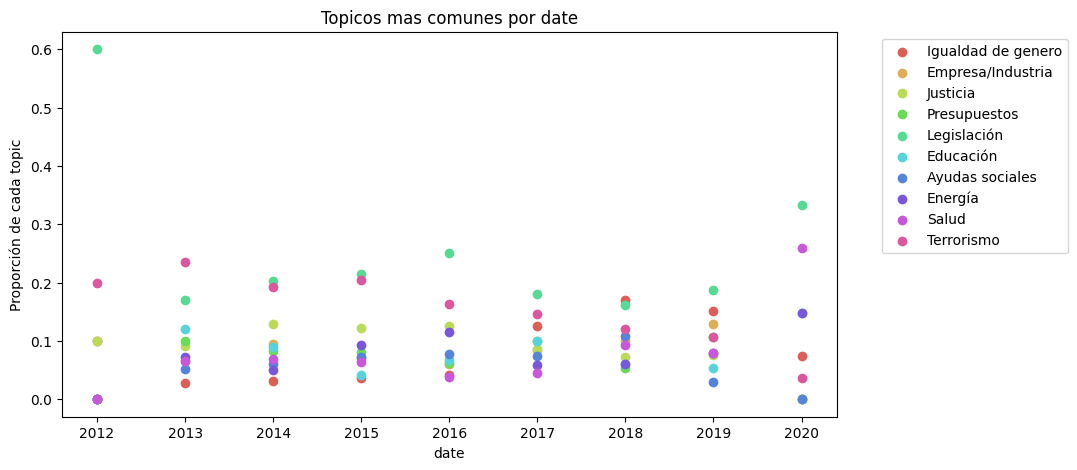

In [ ]:
mostrar_clasificacion(modelo1, topics1, df, "date", topics_model1)

Igualdad de genero  Empresa/Industria  Justicia  Presupuestos   
ARARTEKO            0.600000           0.000000  0.200000      0.000000  \
EAJ                 0.074953           0.082068  0.074478      0.074478   
EB                       NaN                NaN       NaN           NaN   
EH Bildu            0.075397           0.141534  0.121693      0.064815   
EP                  0.257928           0.133192  0.071882      0.071882   
PP                  0.031056           0.050932  0.108075      0.115528   
PSE-EE              0.073265           0.073265  0.150386      0.098972   
UPyD                0.027027           0.013514  0.076577      0.108108   

          Legislación  Educación  Ayudas sociales   Energía     Salud   
ARARTEKO     0.200000   0.000000         0.000000  0.000000  0.000000  \
EAJ          0.276565   0.052182         0.057875  0.078748  0.084915   
EB                NaN        NaN              NaN       NaN       NaN   
EH Bildu     0.070106   0.038360         0.060847  0.051587  0.034392   
EP           0.093023   0.097252         0.069767  0.054968  0.103594   
PP           0.190062   0.134161         0.067081  0.100621  0.053416   
PSE-EE       0.188946   0.111825         0.087404  0.068123  0.047558   
UPyD         0.054054   0.121622         0.094595  0.049550  0.054054   

          Terrorismo  
ARARTEKO    0.000000  
EAJ         0.143738  
EB               NaN  
EH Bildu    0.341270  
EP          0.046512  
PP          0.149068  
PSE-EE      0.100257  
UPyD        0.400901

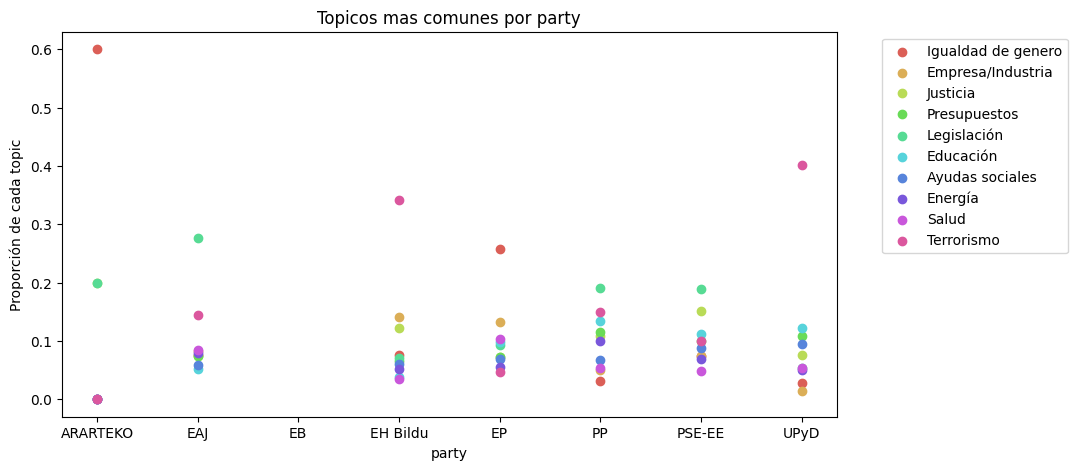

In [ ]:
mostrar_clasificacion(modelo1, topics1, df, "party", topics_model1)

Igualdad de genero  Empresa/Industria  Justicia  Presupuestos  Legislación   
-                 NaN                NaN       NaN           NaN          NaN  \
E            0.135669           0.064107  0.089079      0.080880     0.193067   
G            0.025963           0.110345  0.107911      0.088032     0.192698   

   Educación  Ayudas sociales   Energía     Salud  Terrorismo  
-        NaN              NaN       NaN       NaN         NaN  
E   0.086098         0.062616  0.085352  0.061126    0.142005  
G   0.071805         0.071400  0.059635  0.073834    0.198377

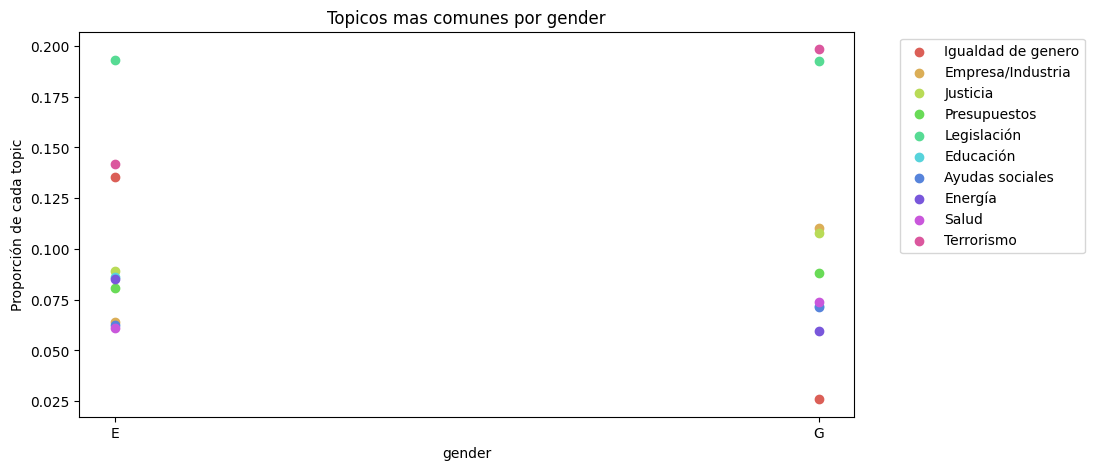

In [ ]:
mostrar_clasificacion(modelo1, topics1, df, "gender", topics_model1)

####Modelo 2

In [35]:
topics2 = clasificar_documentos(modelo2, 0.6, 150, df)

Igualdad de genero  Empresa/Industria  Justicia  Presupuestos   
2012            0.125000           0.000000  0.125000      0.000000  \
2013            0.017843           0.055081  0.069822      0.108611   
2014            0.020721           0.060360  0.086486      0.110811   
2015            0.019250           0.047619  0.146910      0.103343   
2016            0.038961           0.064935  0.085137      0.083694   
2017            0.071429           0.052747  0.097802      0.119780   
2018            0.104308           0.083900  0.074830      0.081633   
2019            0.058419           0.092784  0.064147      0.135166   
2020            0.072727           0.000000  0.072727      0.090909   

      Legislación  Educación  Ayudas sociales   Energía     Salud  Seguridad   
2012     0.250000   0.000000         0.125000  0.000000  0.000000   0.000000  \
2013     0.145074   0.114818         0.043445  0.019395  0.049651   0.068270   
2014     0.118018   0.132432         0.038739  0.015315  0.062162   0.068468   
2015     0.126646   0.100304         0.018237  0.038501  0.082067   0.084093   
2016     0.196248   0.128427         0.031746  0.050505  0.090909   0.041847   
2017     0.080220   0.145055         0.058242  0.041758  0.068132   0.062637   
2018     0.072562   0.129252         0.061224  0.062358  0.107710   0.047619   
2019     0.103093   0.096220         0.011455  0.083620  0.111111   0.077892   
2020     0.109091   0.181818         0.000000  0.000000  0.309091   0.018182   

      Sindicatos  Terrorismo  Vivienda    Presos     Banca  Fiscalidad  
2012    0.000000    0.000000  0.000000  0.375000  0.000000    0.000000  
2013    0.056633    0.117145  0.019395  0.027153  0.060512    0.027153  
2014    0.036937    0.091892  0.021622  0.031532  0.090991    0.013514  
2015    0.036474    0.060790  0.032421  0.018237  0.063830    0.021277  
2016    0.030303    0.044733  0.047619  0.020202  0.017316    0.027417  
2017    0.049451    0.024176  0.025275  0.031868  0.013187    0.058242  
2018    0.058957    0.028345  0.021542  0.019274  0.013605    0.032880  
2019    0.038946    0.017182  0.036655  0.026346  0.016037    0.030928  
2020    0.036364    0.000000  0.000000  0.036364  0.072727    0.000000

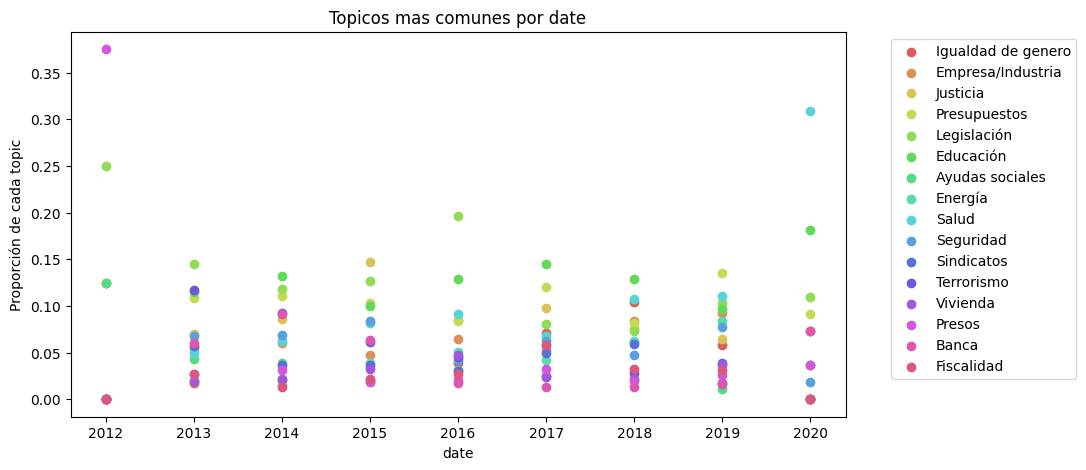

In [ ]:
mostrar_clasificacion(modelo2, topics2, df, "date", topics_model2)

Igualdad de genero  Empresa/Industria  Justicia  Presupuestos   
ARARTEKO                 NaN                NaN       NaN           NaN  \
EAJ                 0.033380           0.062239  0.091794      0.148470   
EB                  0.000000           0.000000  0.000000      0.000000   
EH Bildu            0.050980           0.129412  0.084967      0.086275   
EP                  0.160000           0.100000  0.063636      0.038182   
PP                  0.030303           0.034512  0.094276      0.085859   
PSE-EE              0.040976           0.053659  0.102439      0.080000   
UPyD                0.010025           0.010025  0.062657      0.070175   

          Legislación  Educación  Ayudas sociales   Energía     Salud   
ARARTEKO          NaN        NaN              NaN       NaN       NaN  \
EAJ          0.102573   0.164812         0.026773  0.040334  0.095619   
EB           1.000000   0.000000         0.000000  0.000000  0.000000   
EH Bildu     0.069281   0.035294         0.054902  0.078431  0.040523   
EP           0.067273   0.081818         0.047273  0.069091  0.154545   
PP           0.156566   0.120370         0.039562  0.037037  0.071549   
PSE-EE       0.187317   0.113171         0.055610  0.018537  0.061463   
UPyD         0.125313   0.042607         0.020050  0.010025  0.022556   

          Seguridad  Sindicatos  Terrorismo  Vivienda    Presos     Banca   
ARARTEKO        NaN         NaN         NaN       NaN       NaN       NaN  \
EAJ        0.058067    0.036161    0.037204  0.030250  0.025730  0.019124   
EB         0.000000    0.000000    0.000000  0.000000  0.000000  0.000000   
EH Bildu   0.061438    0.077124    0.032680  0.016993  0.047059  0.079739   
EP         0.032727    0.063636    0.010909  0.025455  0.020000  0.012727   
PP         0.102694    0.030303    0.085017  0.025253  0.022727  0.048822   
PSE-EE     0.048780    0.061463    0.028293  0.032195  0.016585  0.073171   
UPyD       0.097744    0.017544    0.345865  0.027569  0.027569  0.100251   

          Fiscalidad  
ARARTEKO         NaN  
EAJ         0.027469  
EB          0.000000  
EH Bildu    0.054902  
EP          0.052727  
PP          0.015152  
PSE-EE      0.026341  
UPyD        0.010025

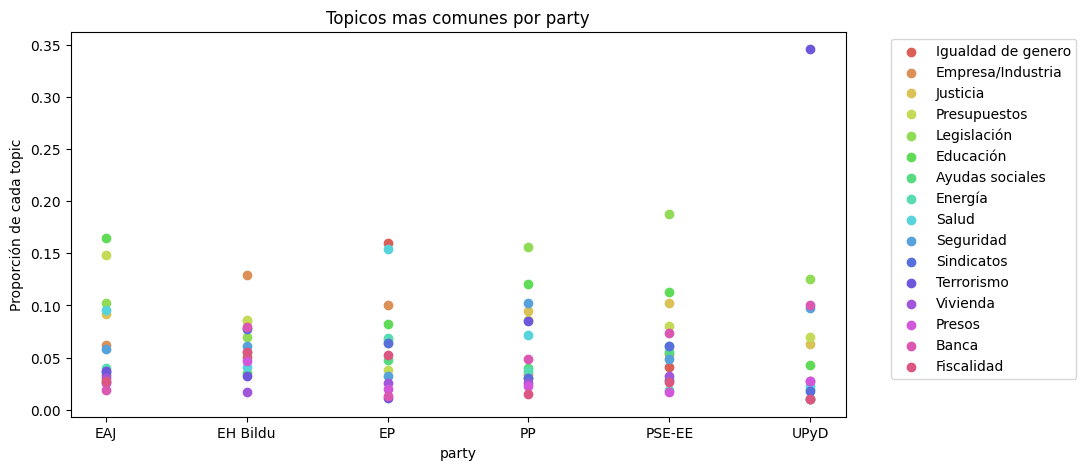

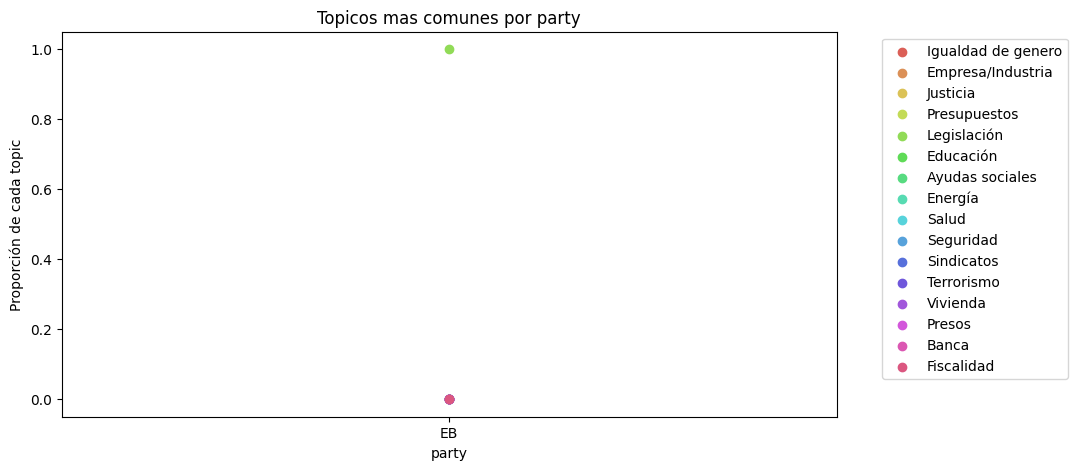

In [ ]:
mostrar_clasificacion(modelo2, topics2, df, "party", topics_model2)

Igualdad de genero  Empresa/Industria  Justicia  Presupuestos  Legislación   
E            0.070572           0.049651  0.077545      0.144212     0.107392  \
G            0.016144           0.079168  0.101832      0.065197     0.133188   

   Educación  Ayudas sociales   Energía     Salud  Seguridad  Sindicatos   
E   0.180195         0.039888  0.038773  0.071409   0.059972    0.032915  \
G   0.054952         0.035393  0.044086  0.090655   0.070785    0.057746   

   Terrorismo  Vivienda    Presos     Banca  Fiscalidad  
E    0.044630  0.020363  0.020084  0.018410    0.023989  
G    0.076374  0.035703  0.032288  0.071406    0.035082

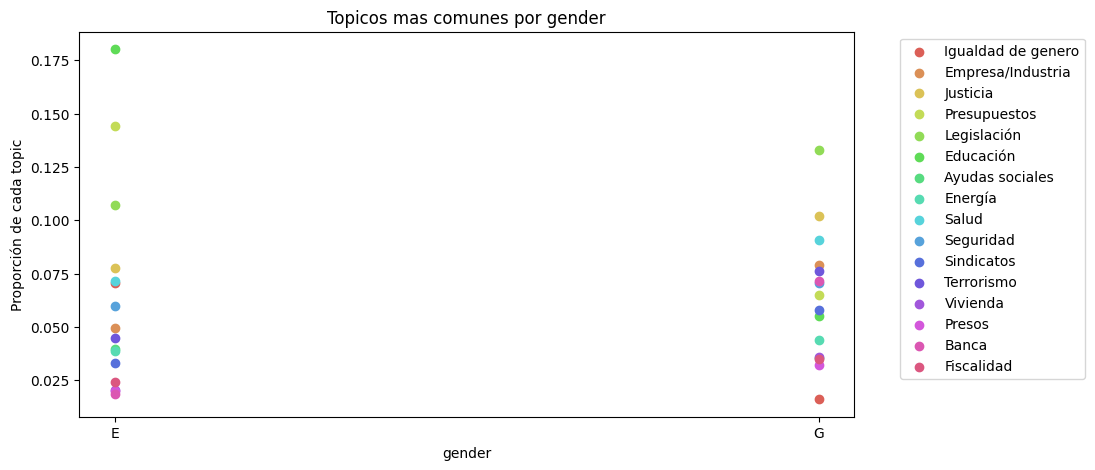

In [ ]:
mostrar_clasificacion(modelo2, topics2 , df, "gender", topics_model2)

####Modelo 3

In [36]:
topics3 = clasificar_documentos(modelo3, 0.6, 300, df)

Igualdad de genero  Empresa/Industria  Justicia  Presupuestos   
2012            0.250000           0.000000  0.000000      0.000000  \
2013            0.026764           0.043796  0.059611      0.115572   
2014            0.032043           0.060080  0.077437      0.084112   
2015            0.021307           0.041193  0.134943      0.068182   
2016            0.025370           0.059197  0.099366      0.067653   
2017            0.096933           0.051534  0.041718      0.095706   
2018            0.153203           0.068245  0.050139      0.076602   
2019            0.115331           0.091421  0.045007      0.104079   
2020            0.057143           0.000000  0.057143      0.000000   

      Legislación  Educación  Ayudas sociales   Energía     Salud  Seguridad   
2012     0.500000   0.000000         0.000000  0.000000  0.000000   0.000000  \
2013     0.160584   0.059611         0.068127  0.027981  0.031630   0.068127   
2014     0.166889   0.037383         0.058745  0.034713  0.026702   0.042724   
2015     0.157670   0.034091         0.058239  0.048295  0.031250   0.073864   
2016     0.202960   0.061311         0.065539  0.059197  0.035941   0.027484   
2017     0.131288   0.074847         0.068712  0.055215  0.039264   0.051534   
2018     0.143454   0.057103         0.034819  0.050139  0.059889   0.041783   
2019     0.137834   0.036568         0.028129  0.066104  0.052039   0.098453   
2020     0.171429   0.085714         0.000000  0.057143  0.200000   0.000000   

      Terrorismo  Vivienda  Fiscalidad  Sindicatos  Corrupción  
2012    0.000000  0.000000    0.250000    0.000000    0.000000  
2013    0.178832  0.013382    0.071776    0.035280    0.038929  
2014    0.134846  0.026702    0.049399    0.018692    0.149533  
2015    0.110795  0.021307    0.049716    0.024148    0.125000  
2016    0.122622  0.014799    0.021142    0.035941    0.101480  
2017    0.094479  0.031902    0.078528    0.033129    0.055215  
2018    0.090529  0.027855    0.037604    0.030641    0.077994  
2019    0.084388  0.063291    0.018284    0.018284    0.040788  
2020    0.028571  0.000000    0.000000    0.000000    0.342857

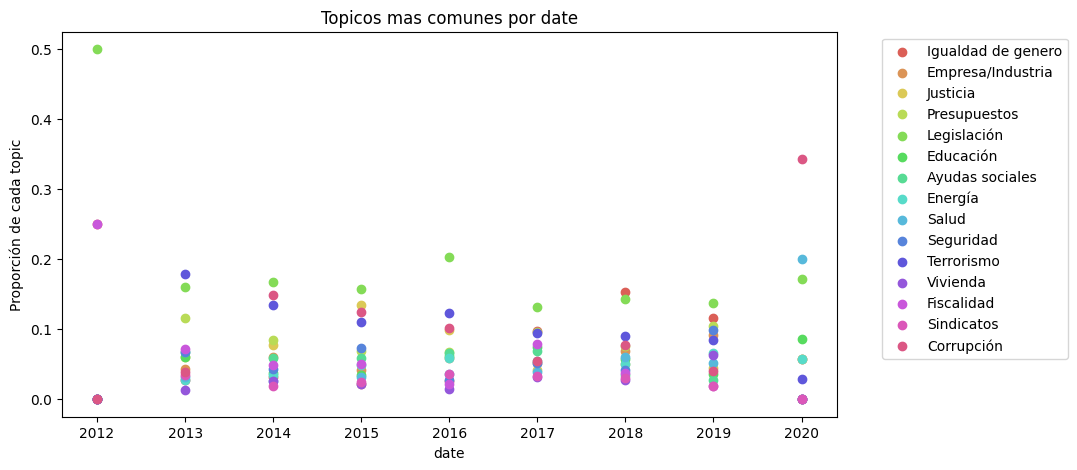

In [ ]:
mostrar_clasificacion(modelo3, topics3, df, "date", topics_model3)

Igualdad de genero  Empresa/Industria  Justicia  Presupuestos   
EAJ                 0.063584           0.053950  0.098266      0.064066  \
EB                       NaN                NaN       NaN           NaN   
EH Bildu            0.066207           0.092414  0.049655      0.074483   
EP                  0.204322           0.108055  0.015717      0.094303   
PP                  0.020806           0.033810  0.059818      0.141743   
PSE-EE              0.058309           0.042274  0.069971      0.093294   
UPyD                0.019011           0.019011  0.041825      0.140684   

          Legislación  Educación  Ayudas sociales   Energía     Salud   
EAJ          0.223507   0.055395         0.040462  0.045279  0.049615  \
EB                NaN        NaN              NaN       NaN       NaN   
EH Bildu     0.057931   0.017931         0.049655  0.063448  0.011034   
EP           0.062868   0.068762         0.033399  0.053045  0.102161   
PP           0.161248   0.031209         0.089727  0.052016  0.027308   
PSE-EE       0.155977   0.103499         0.087464  0.040816  0.024781   
UPyD         0.041825   0.011407         0.026616  0.022814  0.011407   

          Seguridad  Terrorismo  Vivienda  Fiscalidad  Sindicatos  Corrupción  
EAJ        0.059730    0.109345  0.021676    0.041908    0.021676    0.051541  
EB              NaN         NaN       NaN         NaN         NaN         NaN  
EH Bildu   0.044138    0.288276  0.024828    0.051034    0.038621    0.070345  
EP         0.047151    0.021611  0.043222    0.045187    0.027505    0.072692  
PP         0.083225    0.065020  0.036411    0.063719    0.018205    0.115735  
PSE-EE     0.056851    0.046647  0.039359    0.051020    0.053936    0.075802  
UPyD       0.041825    0.220532  0.015209    0.057034    0.003802    0.326996

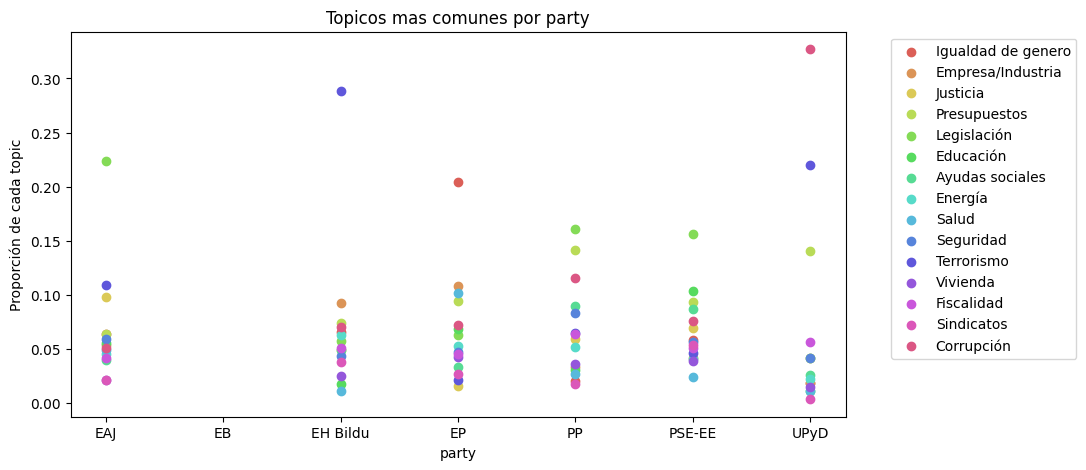

In [ ]:
mostrar_clasificacion(modelo3, topics3, df, "party", topics_model3)

Igualdad de genero  Empresa/Industria  Justicia  Presupuestos   
ARARTEKO                 1.0                0.0       0.0           0.0  \

          Legislación  Educación  Ayudas sociales  Energía  Salud  Seguridad   
ARARTEKO          0.0        0.0              0.0      0.0    0.0        0.0  \

          Terrorismo  Vivienda  Fiscalidad  Sindicatos  Corrupción  
ARARTEKO         0.0       0.0         0.0         0.0         0.0

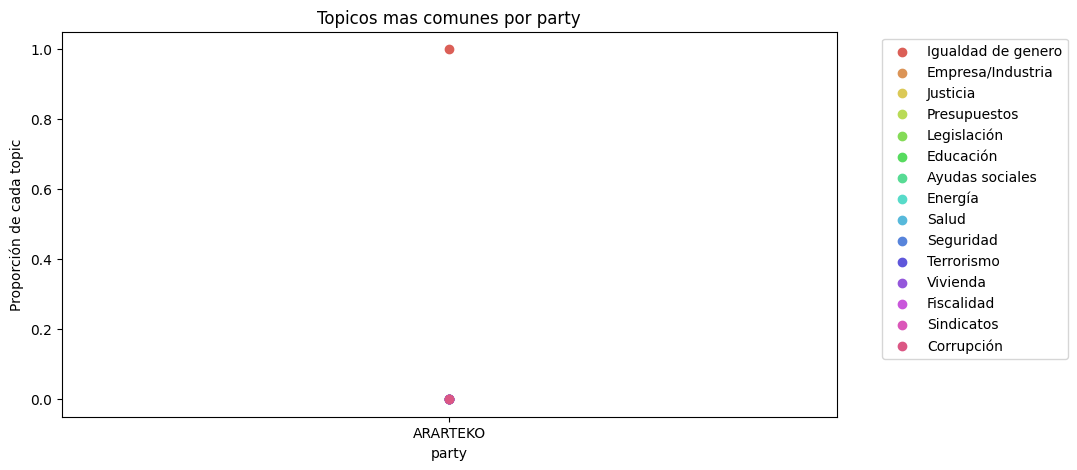

In [ ]:
mostrar_clasificacion(modelo3, topics3, df, "party", topics_model3)

Igualdad de genero  Empresa/Industria  Justicia  Presupuestos  Legislación   
E            0.122971           0.049513  0.041802       0.06737     0.154627  \
G            0.017147           0.067030  0.097428       0.10873     0.155495   

   Educación  Ayudas sociales   Energía     Salud  Seguridad  Terrorismo   
E   0.073864         0.073864  0.049513  0.028815   0.058036    0.136769  \
G   0.030787         0.035464  0.046376  0.051832   0.058846    0.097428   

   Vivienda  Fiscalidad  Sindicatos  Corrupción  
E  0.024351    0.042614    0.023539    0.052354  
G  0.032736    0.054949    0.031567    0.114186

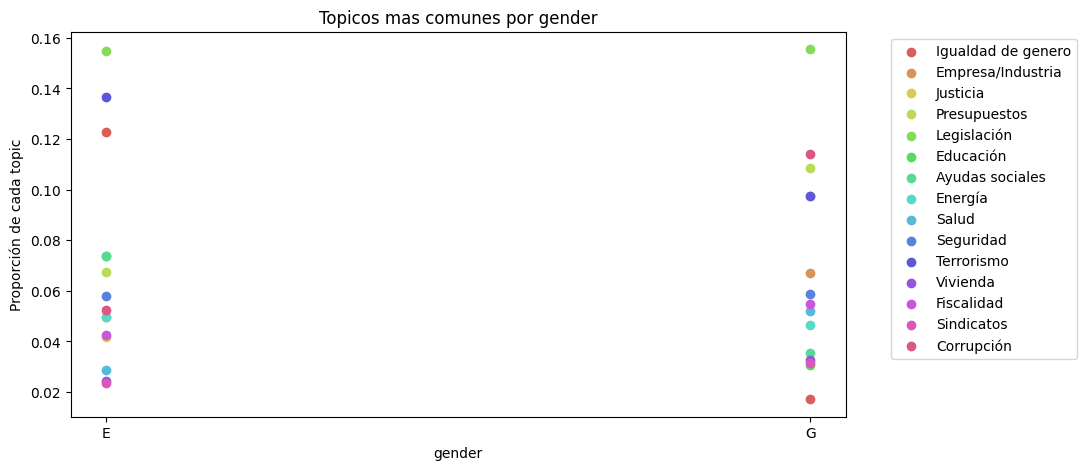

In [ ]:
mostrar_clasificacion(modelo3, topics3, df, "gender", topics_model3)

###Ejemplos de clasificación

In [64]:
def generar_ejemplos(modelo_lda, topics, data, mapeo, cuantos, topico):
    # Crear un DataFrame con los textos y los números de los tópicos asignados
    ejemplos = pd.DataFrame({
        'Texto': data['text'],
        'Topico': [mapeo.get('Topico{}'.format(topic), '') for topic in topics.argmax(axis=1)]
    })
  
    ejemplos = ejemplos[ejemplos['Topico'] != '']
    
    if topico != '':
      ejemplos = ejemplos[ejemplos['Topico'] == topico]
      
    return ejemplos[:cuantos]

In [72]:
#Ejemplo para generar 5 ejemplos de documentos que tratan sobre Igualdad de genero según el modelo 3
generar_ejemplos(modelo3, topics3, df, topics_model3, 5, 'Igualdad de genero')

Texto              Topico
0   Lejos del mito de que en las generaciones más ...  Igualdad de genero
5   "Hoy es también un día de celebración por los ...  Igualdad de genero
11  "El Parlamento Vasco hace un llamamiento a las...  Igualdad de genero
17  "El Parlamento Vasco condena dicha muerte así ...  Igualdad de genero
22  "El Parlamento Vasco insta a la ciudadanía a a...  Igualdad de genero